# Calculate CAPE for a Littlerock sounding

In [1]:
import numpy as np
import pandas as pd
import h5py
from pprint import pformat
from importlib import reload
import a405thermo.thermlib
reload(a405thermo.thermlib)
from a405thermo.constants import constants as c
from a405thermo.thermlib import convertSkewToTemp, convertTempToSkew
import a405skewT.makeSkewII
reload(a405skewT.makeSkewII)
from a405skewT.makeSkewII import makeSkewWet

In [2]:
filename='single_littlerock.h5';
print('reading file: %s\n' %filename)

attributes={}
with h5py.File(filename,'r') as f:
    keys=f.attrs.keys()
    for key in keys:
        try:
            attributes[key]=f.attrs[key]
        except IOError:
            print('empty key: ',key)
print('\nread in these attributes: \n\n',pformat(attributes))

separator= '\n' + '+'*30 + '\n'
sounding_dict={}
with pd.HDFStore(filename,'r') as store:
    times=store.keys()
    for the_time in times:
        sounding_dict[the_time]=store[the_time]
sounding=sounding_dict[times[3]]
# print('{0:}sounding times:{1:}{0:} '.format(separator,times))
# print('{0:}columns: {1:}{0:} '.format(separator,pformat(sounding.columns)))
title_string=attributes['header']
index=title_string.find(' Observations at')
location=title_string[:index]
title='{} at {}'.format(location,times[0][2:])
print('title: :',title)
units=attributes['units'].split(';')
units_dict={}
for count,var in enumerate(sounding.columns):
    units_dict[var]=units[count]

reading file: single_littlerock.h5

empty key:  TITLE
empty key:  CLASS
empty key:  VERSION
empty key:  PYTABLES_FORMAT_VERSION

read in these attributes: 

 {'elevation': 1.0,
 'header': '72340 LZK Little Rock Observations at 00Z 01 Mar 2012',
 'history': 'written by test_requests.py',
 'latitude': 34.829999999999998,
 'longitude': -92.269999999999996,
 'site_id': '72340',
 'units': 'hPa;m;C;C;%;g/kg;deg;knot;K;K;K'}
title: : 72340 LZK Little Rock at 2012_Mar_01_00Z


In [3]:
skew=30.
triplets=zip(sounding['temp'],sounding['dwpt'],sounding['pres'])
xcoord_T=[]
xcoord_Td=[]
for a_temp,a_dew,a_pres in triplets:
    xcoord_T.append(convertTempToSkew(a_temp,a_pres,skew))
    xcoord_Td.append(convertTempToSkew(a_dew,a_pres,skew))

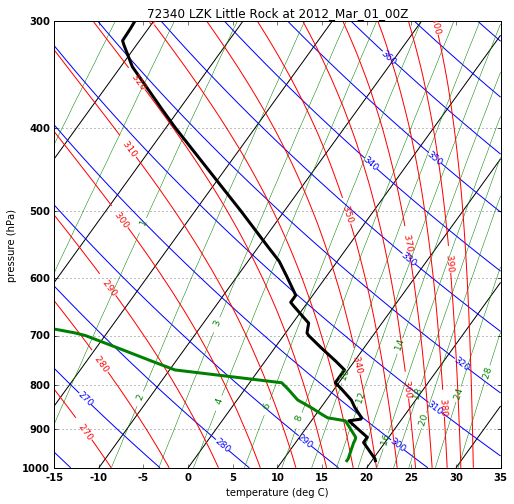

In [4]:
%matplotlib inline
skew=30
plt.close('all')
fig,ax =plt.subplots(1,1,figsize=(8,8))
corners=[-15,35]
ax,skew = makeSkewWet(ax,corners=corners,skew=skew)
ax.plot(xcoord_T,sounding['pres'],color='k',label='temp')
ax.plot(xcoord_Td,sounding['pres'],color='g',label='dew')
[line.set(linewidth=3) for line in ax.lines[-2:]]
out=ax.set(title=title)

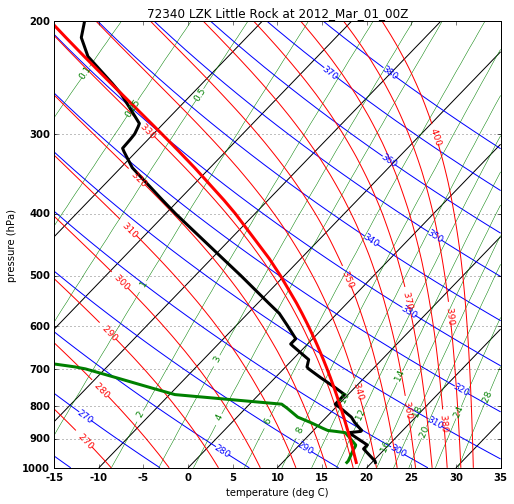

In [5]:
from a405thermo.thermlib import find_Tmoist,find_thetaep,find_rsat,find_Tv
#
# find thetae of the surface air
#
sfc_press,sfc_temp,sfc_Td =[sounding[key][0] for key in ['pres','temp','dwpt']]
sfc_press,sfc_temp,sfc_Td = sfc_press*100.,sfc_temp+c.Tc,sfc_Td+c.Tc
sfc_rvap = find_rsat(sfc_Td,sfc_press)
sfc_thetae=find_thetaep(sfc_Td,sfc_temp,sfc_press)
press=sounding['pres'].values*100.
#
# find the index for 200 hPa pressure -- searchsorted requires
# the pressure array to be increasing, so flip it for the search,
# then flip the index.  Above 100 hPa thetae goes bananas, so
# so trim so we only have 
#
toplim=len(press) - np.searchsorted(press[::-1],1.5e4)
clipped_press=press[:toplim]
#
# find temps along that adiabat
#
adia_temps= np.array([find_Tmoist(sfc_thetae,the_press) for the_press in clipped_press])
adia_rvaps = find_rsat(adia_temps,clipped_press)
adia_rls = sfc_rvap - adia_rvaps
env_temps = (sounding['temp'].values + c.Tc)[:toplim]
env_Td = (sounding['dwpt'].values + c.Tc)[:toplim]
height = sounding['hght'].values[:toplim]
pairs = zip(env_Td,clipped_press)
env_rvaps= np.array([find_rsat(td,the_press) for td,the_press in pairs])
env_Tv = find_Tv(env_temps,env_rvaps)
adia_Tv = find_Tv(adia_temps,adia_rvaps,adia_rls)
xcoord_thetae=[]
clipped_press_hPa = clipped_press*1.e-2
for a_temp,a_press in zip(adia_temps - c.Tc,clipped_press_hPa):
    out=convertTempToSkew(a_temp,a_press,skew)
    xcoord_thetae.append(out)
ax.plot(xcoord_thetae,clipped_press_hPa,color='r',label='rsat',linewidth=3.)
ax.set(ylim=[1000.,200.])
display(fig)

pressure,   695 hPa  dewpoint   250 K , temp   276 K
cloud thetae 331.748 K, env_thetae 308.537 K


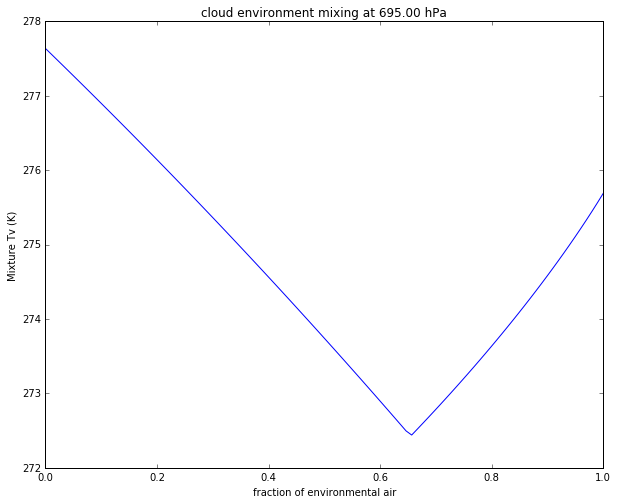

In [7]:
plt.close('all')
from a405thermo.thermlib import tinvert_thetae
mix_level=np.searchsorted(clipped_press[::-1],700.e2)
index=len(clipped_press) - mix_level
mix_press = clipped_press[index]
print('pressure, {:5.3g} hPa  dewpoint {:5.3g} K , temp {:5.3g} K'\
      .format(clipped_press[index]*1.e-2,env_Td[index],env_temps[index]))
env_thetae = find_thetaep(env_Td[index],env_temps[index],clipped_press[index])
env_rvap = env_rvaps[index]
print('cloud thetae {:5.3f} K, env_thetae {:5.3f} K'.format(sfc_thetae,env_thetae))
fenv=np.linspace(0,1,100.)
logthetae_mix = fenv*np.log(env_thetae) + (1 - fenv)*np.log(sfc_thetae)
rTot_mix = fenv*env_rvap  + (1 - fenv)*sfc_rvap
thetae_mix = np.exp(logthetae_mix)
pairs = zip(thetae_mix,rTot_mix)
Tvlist = []
for thetae,rtot in pairs:
    temp,rv,rl = tinvert_thetae(thetae,rtot,mix_press)
    Tvlist.append(find_Tv(temp,rv,rl))
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(fenv,Tvlist)
title='cloud environment mixing at {:5.2f} hPa'.format(clipped_press[index]*1.e-2)
out=ax.set(xlabel='fraction of environmental air',ylabel='Mixture Tv (K)',title=title)